<b><h1>Natural Language Processing: Fine-Tuning Large Language Models</h1></b>




In this notebook we  will fine-tune a Large Language Model (LLM) for one selected African language(Xhosa) based on the availability of pretrained models and training data








In [ ]:
## Install and import anything required. Capture hides the output from the cell.
%%capture
# @title Install and import required packages. (Run Cell)

!pip install livelossplot
!pip install colorama  # print colors :).

#!pip install transformers datasets
#!pip install seaborn umap-learn
#!pip install livelossplot
!pip install datasets
#!pip install -q transformers[torch]
!pip install accelerate
!pip install --upgrade peft

# Python utils
#!pip install -q ipdb      # debugging.
#!pip install -q colorama  # print colors :).

import os
import math
import urllib.request

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if os.environ["COLAB_GPU"] and int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
else:
    print("Only CPU accelerator is connected.")

# https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html#gpu-memory-allocation
# Avoid GPU memory allocation to be done by JAX.
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

# note that jax might not run on a GPU here in colab, however we are not actually training jax models in this notebook
import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax

import transformers
from transformers import pipeline, AutoTokenizer, AutoModel
import datasets
import peft

from PIL import Image
from livelossplot import PlotLosses

# Utils.
import colorama

import torch
#import torchvision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import itertools
import random

# download images used in notebook
urllib.request.urlretrieve(
    "https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80",
    "cat.png",
)

import copy

import gensim
from nltk.data import find
import nltk

nltk.download("word2vec_sample")

import huggingface_hub
import ipywidgets as widgets
from IPython.display import display

!pip install sacrebleu
!pip install evaluate

#Data Preprocessing

The first step in this project is data processing. It consist firstly to data loading, data cleaning and tokenization

Load the Dataset

The initial fine-tuning dataset to use is the “Aya Dataset”, a human annotated multilingual instruction fine-tuning dataset.

In [ ]:
from datasets import load_dataset

# Load the annotations dataset
aya_dataset = load_dataset("CohereForAI/aya_dataset")
language = "Xhosa"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/202362 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1750 [00:00<?, ? examples/s]

Before doing tokeniwqtion, we need to load the tokenizer as following:

In [ ]:
# Load the tokeniwer
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name ="bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

We can then load the aya dataset, clean and tokenize it

In [ ]:
from datasets import load_dataset

# Choose the Swahili language dataset
aya_dataset = load_dataset("CohereForAI/aya_dataset")
train_dataset = aya_dataset["train"].filter(lambda example: example["language"] in [language])
dada_not_use = ['annotation_type', 'user_id', 'language_code']
train_dataset = train_dataset.remove_columns(dada_not_use)
train_dataset = train_dataset.filter(lambda x: len(x['inputs']) > 0 and len(x['targets'])>0)

Filter:   0%|          | 0/202362 [00:00<?, ? examples/s]

Filter:   0%|          | 0/377 [00:00<?, ? examples/s]

In [ ]:
import re
def remove_punctuation(input):
    """Function that takes in a string and removes all punctuation."""

    # for i in range(len(input)):
    input = re.sub(r"[^\w\s]", "", input)
    return input

In [ ]:
train_dataset = train_dataset.map(lambda example: {'new': remove_punctuation(example['inputs'])})
train_dataset = train_dataset.remove_columns('inputs')
train_dataset = train_dataset.rename_column('new', 'inputs')

train_dataset = train_dataset.map(lambda example: {'new': remove_punctuation(example['targets'])})
train_dataset = train_dataset.remove_columns('targets')
train_dataset = train_dataset.rename_column('new', 'targets')
train_dataset

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

Dataset({
    features: ['language', 'inputs', 'targets'],
    num_rows: 377
})

We can then load the `aya_dataset` dataset and tokenize it

In [ ]:
max_num_tokens = 256
def tokenize(prompt):
  result = tokenizer(
      prompt,
      truncation=True,
      max_length=max_num_tokens,
      padding="max_length",
  )
  return {
      "input_ids": result["input_ids"],
      "attention_mask": result["attention_mask"],
  }

train_filtered = train_dataset.shuffle().map(lambda x: tokenize(x["inputs"]))

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

For the test set, we are using `aya_evaluation_suite` dataset which contain more languages (Xhosa included)

In [ ]:
aya_eval = load_dataset("CohereForAI/aya_evaluation_suite", "dolly_machine_translated")
test_dataset = aya_eval["test"].filter(lambda example: example["language"] in ['xho'])
test_dataset = test_dataset.shuffle().map(lambda x: tokenizer(x["inputs"]))
test_dataset

Generating test split:   0%|          | 0/23800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/23800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'inputs', 'targets', 'language', 'script', 'source_id', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [ ]:
test_dataset = test_dataset.map(lambda example: {'new': remove_punctuation(example['inputs'])})
test_dataset = test_dataset.remove_columns('inputs')
test_dataset = test_dataset.rename_column('new', 'inputs')

test_dataset = test_dataset.map(lambda example: {'new': remove_punctuation(example['targets'])})
test_dataset = test_dataset.remove_columns('targets')
test_dataset = test_dataset.rename_column('new', 'targets')
test_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'language', 'script', 'source_id', 'input_ids', 'attention_mask', 'inputs', 'targets'],
    num_rows: 200
})

In the following cell, we split the `aya_dataset` in 2: 80% for the training set and 20% for the validation set.

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_dataset, validation_dataset = train_test_split(train_filtered ,
                                                     test_size= 0.2 ,
                                                     random_state=42
                                                     )

train_dataset = Dataset.from_dict(train_dataset)
validation_dataset = Dataset.from_dict(validation_dataset)
validation_dataset

Dataset({
    features: ['language', 'inputs', 'targets', 'input_ids', 'attention_mask'],
    num_rows: 76
})

# Loading of the baseline model

We load the BLOOM 560M from hugging face and simulate some sample to understand how it works


In [ ]:
if 'bigscience/bloom-560m' in model_name:
  tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
  model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
else:
  raise NotImplementedError

if torch.cuda.is_available():
  model = model.to("cuda")

tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
def run_sample(
    model,
    tokenizer,
    prompt: str,
    seed: int | None = None,
    temperature: float = 0.6,
    top_p: float = 0.9,
    max_new_tokens: int = 64,
) -> str:
    inputs = tokenizer(prompt, return_tensors="pt")

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    generation_config = transformers.GenerationConfig(
      do_sample=True,
      temperature=temperature,
      top_p=top_p,
      pad_token_id=tokenizer.pad_token_id,
      top_k=0,
    )

    if seed is not None:
      torch.manual_seed(seed)

    generation_output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_new_tokens,
        generation_config=generation_config,
    )

    assert len(generation_output.sequences) == 1
    output_sequence = generation_output.sequences[0]
    output_string = tokenizer.decode(output_sequence)
    response = output_string.split(prompt)[1].rstrip()

    return response

In [ ]:
run_sample(model=model,
           tokenizer=tokenizer,
           prompt='What is a dog ?')

' A dog is a small animal that is used for hunting, fishing, and other recreational purposes. The term dog originated in the Old English dog, which was a small animal that was used for hunting, fishing, and other recreational purposes. Dogs were first used to hunt deer, and later in the 19th century'

# Fine-tuning BLOOM with Hagging Face

With the advent of increasingly large and sophisticated pre-trained models, a new challenge emerges as to how to customise these powerful models for distinct tasks or domains without incurring prohibitive computational costs. Traditional fine-tuning methods, which involve retraining vast areas of model parameters, are no longer viable due to their heavy computational demands and time-consuming processes. In this section, we are exploring LoRA, prefix-tuning and adapters methods.

## Fine-tuning using LoRA method

Now let's implement the LoRA module!

Before doing so, there're a couple of parameters / configs associated with LoRA:

1. **target_modules**: Which layers or transformer matrices (Q, K, V) we should apply LoRA to?  
2. **lora_rank**: What is the size of the rank to be used.  
3. **lora_alpha**: This is used for scaling. This scaling helps to reduce the need to retune hyperparameters when we vary `lora_rank`. When optimizing with Adam, tuning `lora_alpha` is roughly the same as tuning the learning
rate if we scale the initialization appropriately.
4. **initialization**: We use a random Gaussian initialization for `A` and
zero for `B`.   
5. **dropout**: as usually applied in Deep Learning models.


The first thing to do now is to set our hyperparameters for training.

In [ ]:
MICRO_BATCH_SIZE = 4
BATCH_SIZE = 32
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
EPOCHS = 30
LEARNING_RATE = 3e-4
# CUTOFF_LEN = max_num_tokens
LORA_R = 26
LORA_ALPHA = 26
LORA_DROPOUT = 0.5

Now we load our model in using the PEFT library. Remember, the PEFT library is where all these optimisation and efficient training methods are created in.

In [ ]:
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.CAUSAL_LM,
    inference_mode=False,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=None,
)
peft_model = peft.get_peft_model(copy.deepcopy(model), peft_config)
peft_model.print_trainable_parameters()

trainable params: 2,555,904 || all params: 561,770,496 || trainable%: 0.4549729859789575


The following cell define the training arguments for the LoRA

### Training

In [ ]:
# Training Configuration
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,  # Enable mixed precision training
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=int(0.01 * len(train_dataset) * MICRO_BATCH_SIZE // BATCH_SIZE * EPOCHS),
    lr_scheduler_type="cosine",
    output_dir="tmp",
    save_strategy="no",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    eval_steps = len(train_dataset),
)

Everything defined, we can now train the model

In [ ]:
from accelerate import DataLoaderConfiguration

dataloader_config = DataLoaderConfiguration(
    dispatch_batches=None,
    split_batches=False
)

# Trainer
trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    args=training_arguments,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)

peft_model.config.use_cache = False
trainer.train(resume_from_checkpoint=False)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,12.733400,9.362799
2,3.441500,2.094847
4,1.413100,1.389428
6,1.289100,1.272862
8,1.167100,1.223754
10,1.158100,1.191539
12,1.065600,1.169811
14,1.032700,1.151827
16,1.008300,1.141371
18,0.973300,1.133064


TrainOutput(global_step=270, training_loss=1.7025481188738787, metrics={'train_runtime': 721.6788, 'train_samples_per_second': 12.512, 'train_steps_per_second': 0.374, 'total_flos': 4006598217302016.0, 'train_loss': 1.7025481188738787, 'epoch': 28.42})

The following cell allow us to extract the losses qnd learning rates and plot them

In [ ]:
def extract_losses_lr(trainer):
  train_loss = []
  eval_loss = []
  learning_rates = []
  for element in trainer.state.log_history:
    if 'loss' in element.keys():
      train_loss.append(element['loss'])
      learning_rates.append(element['learning_rate'])

  for element in trainer.state.log_history:
    if 'eval_loss' in element.keys():
      eval_loss.append(element['eval_loss'])

  return train_loss, eval_loss, learning_rates

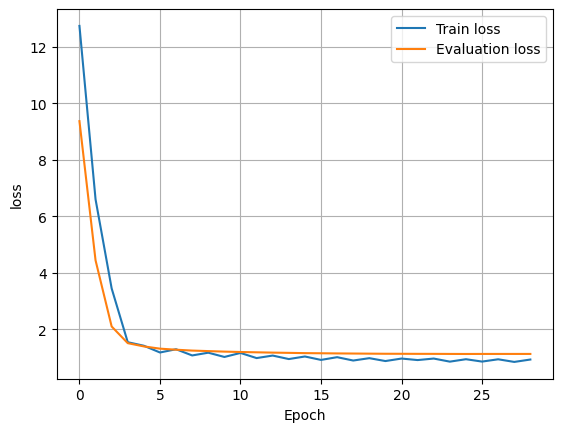

In [ ]:
train_loss, eval_loss, learning_rates = extract_losses_lr(trainer)
plt.plot(train_loss, label='Train loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.savefig('losses_loRA.pdf', format='pdf')
plt.show()

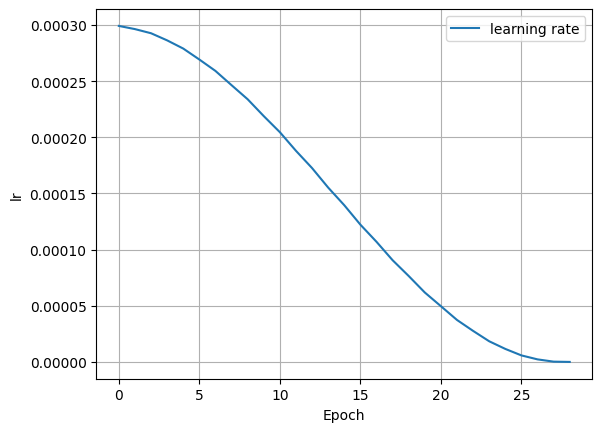

In [ ]:
plt.plot(learning_rates, label='learning rate')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('lr')
plt.legend()
plt.savefig('LoRA_lr.pdf', format='pdf')
plt.show()

### Model testing

For testing the model, we use chrF++ defined as following

\begin{equation}
    \text{chrF++} = \frac{(1+\beta^2)\times \text{precision}\times \text{recall}}{(\beta^2 \times \text{precision}) + \text{recall}}
\end{equation}
Where:


* Precision: The ratio of the number of correctly predicted characters to the total number of predicted characters.
* Recall: The ratio of the number of correctly predicted characters to the total number of reference characters.
* $\beta$: A parameter that controls the importance of recall in the calculation. The value of 1.5 is used


In [ ]:
from tqdm import tqdm
import sacrebleu
import evaluate

def compute_chrFpp(peft_model, tokenizer, test_dataset, beta=1.5):
  references = [example["targets"] for example in test_dataset]

  # Move model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  peft_model.to(device)

  # generate response
  generated_responses = []
  for example in tqdm(test_dataset, desc="Prediction"):
    prompt = example["inputs"]
    response = run_sample(
        peft_model,
        tokenizer,
        prompt=prompt,
        seed=42,
        temperature=0.8,
        top_p=0.9,
    )
    generated_responses.append(response)

  # compute chrF++
  chrFpp_scores = []
  for reference, generated_response in tqdm(zip(references, generated_responses), desc="Compute ChrF++"):
    min_len = min(len(reference), len(generated_response))
    chrf = evaluate.load("chrf", config_name='chrf++', trust_remote_code=True)
    score = chrf.compute(predictions=generated_response[:min_len],
                         references=reference[:min_len],
                         beta=beta)
    chrFpp_scores.append(score['score'])


  # Average the chrF++ scores
  average_chrFpp_score = sum(chrFpp_scores) / len(chrFpp_scores)

  return average_chrFpp_score

In [ ]:
chrF = compute_chrFpp(peft_model, tokenizer, test_dataset)
print('\nAverage chrF++ score', chrF)

Prediction: 100%|██████████| 200/200 [05:39<00:00,  1.70s/it]
Compute ChrF++: 0it [00:00, ?it/s]

Compute ChrF++: 200it [02:23,  1.40it/s]


Average chrF++ score 5.688603610264255


Let's generate the answer of the question: Yintoni inja ? (What is a dog ?)

# Prefix-tuning

Prefix tuning works by introducing a trainable token/tensor into each transformer block along with the input tokens, as opposed to solely modifying the input tokens (prompt engineering) or finetuning the entire transformer bloc. The contrast between a standard transformer block and a transformer block enhanced with a prefix is depicted in the following figure. This was first introduce in the ["Prefix-Tuning: Optimizing Continuous Prompts for Generation" paper](https://arxiv.org/abs/2101.00190) by Xiang Lisa Li and Percy Liang.

By only training the "Trainable tokens" and the new introduced MLP layer, we are able to adapt a model to our domain by training close to 0.1% of the parameters of a full model and achieve performance comparable to fine tuning the entire model.

<img src="https://drive.google.com/uc?export=view&id=1fSnk9MkoPN6KbmbP71iU9EViU9avvOHb" alt="drawing" width="230"/>


In [ ]:
MICRO_BATCH_SIZE = 4
BATCH_SIZE = 32
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
EPOCHS = 30
LEARNING_RATE = 1e-2

In [ ]:
# Training Configuration
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=int(0.01 * len(train_dataset) * MICRO_BATCH_SIZE // BATCH_SIZE * EPOCHS),
    lr_scheduler_type="cosine",
    output_dir="tmp",
    save_strategy="no",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    eval_steps = len(train_dataset),
)

In [ ]:
from peft import PrefixEncoder, PrefixTuningConfig

config_prefix = PrefixTuningConfig(
    peft_type="PREFIX_TUNING",
    task_type=peft.TaskType.CAUSAL_LM,
    inference_mode=False,
    num_virtual_tokens=20,
)
peft_model_prefix = peft.get_peft_model(copy.deepcopy(model), config_prefix)
peft_model_prefix.print_trainable_parameters()

trainable params: 983,040 || all params: 560,197,632 || trainable%: 0.1754809274167014


In [26]:
trainer_prefix = transformers.Trainer(
    model=peft_model_prefix,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    args=training_arguments,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)

peft_model_prefix.config.use_cache = False
trainer_prefix.train(resume_from_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,35.338400,10.303401
2,2.740300,1.782753
4,1.451600,1.468806
6,1.397200,1.379138
8,1.280300,1.325401
10,1.280300,1.289339
12,1.187400,1.261753
14,1.164000,1.242684
16,1.151600,1.228964
18,1.125900,1.220285


TrainOutput(global_step=270, training_loss=2.557318662714075, metrics={'train_runtime': 722.6212, 'train_samples_per_second': 12.496, 'train_steps_per_second': 0.374, 'total_flos': 3973008486039552.0, 'train_loss': 2.557318662714075, 'epoch': 28.42})

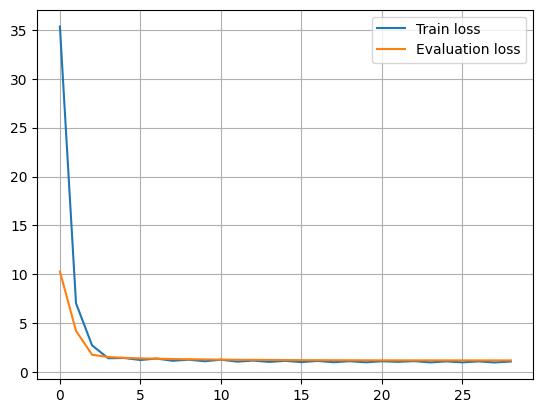

In [27]:
train_loss, eval_loss, learnin_rates = extract_losses_lr(trainer_prefix)
plt.plot(train_loss, label='Train loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.grid(True)
plt.legend()
plt.savefig('prefix_losses.pdf', format='pdf')
plt.show()

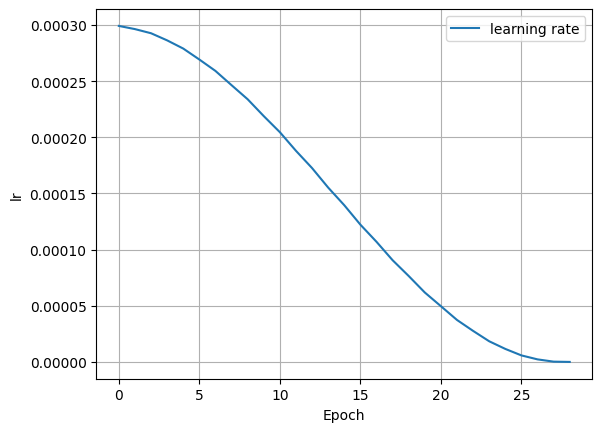

In [28]:
plt.plot(learning_rates, label='learning rate')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('lr')
plt.legend()
plt.savefig('prefix_lr.pdf', format='pdf')
plt.show()

In [29]:
chrFpp = compute_chrFpp(peft_model_prefix, tokenizer, test_dataset)
print(f"\nAverage chrF++ score: {chrFpp}")

Prediction: 100%|██████████| 200/200 [04:58<00:00,  1.49s/it]
Compute ChrF++: 200it [02:23,  1.40it/s]


Average chrF++ score: 5.671187108862332


# Adapters

In [30]:
import torch.nn as nn
class AdapterLayer(nn.Module):
    def __init__(self, config):
        super(AdapterLayer, self).__init__()
        self.adapter = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.adapter(x)
        x = self.activation(x)
        return x

class TransformerBlockWithAdapters(nn.Module):
    def __init__(self, config, adapter1, adapter2):
        super(TransformerBlockWithAdapters, self).__init__()
        self.config = config
        self.adapter1 = adapter1
        self.adapter2 = adapter2
        self.mha = nn.MultiheadAttention(config['hidden_size'],
                                         num_heads=config['num_attention_heads'])
        self.layernorm1 = nn.LayerNorm(config['hidden_size'])
        self.ff = nn.Sequential(
            nn.Linear(config['hidden_size'], config['intermediate_size']),
            nn.ReLU(),
            nn.Linear(config['intermediate_size'], config['hidden_size'])
        )
        self.layernorm2 = nn.LayerNorm(config['hidden_size'])

    def forward(self, tokens, attention_mask=None):
        original_tokens = tokens
        adapted_tokens = self.adapter1(tokens)
        x, _ = self.mha(adapted_tokens, adapted_tokens, adapted_tokens, key_padding_mask=attention_mask)
        x = self.layernorm1(x + original_tokens)
        original_tokens = x
        x = self.adapter2(x)
        x = self.ff(x)
        transformed_tokens = self.layernorm2(x + original_tokens)
        return transformed_tokens


In [31]:
config = {
    'hidden_size': 4,
    'intermediate_size': 4,
    'num_attention_heads': 2
}
transformer_block = TransformerBlockWithAdapters(config, AdapterLayer(config), AdapterLayer(config))

In [32]:
class FineTuningModel(nn.Module):
    def __init__(self, base_model, transformer_block):
        super(FineTuningModel, self).__init__()
        self.base_model = base_model
        self.transformer_block = transformer_block

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        # Assuming Bloom 560M outputs logits directly
        sequence_output = outputs.logits  # Adjust this based on the actual output structure
        transformed_output = self.transformer_block(sequence_output, attention_mask)
        return transformed_output


In [33]:
# Training Configuration
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,  # Enable mixed precision training
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=int(0.01 * len(train_dataset) * MICRO_BATCH_SIZE // BATCH_SIZE * EPOCHS),
    lr_scheduler_type="cosine",
    output_dir="tmp",
    save_strategy="no",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    eval_steps = len(train_dataset),
)

In [ ]:
adapter_model = FineTuningModel(model, transformer_block)

trainer = transformers.Trainer(
    model=adapter_model,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=200,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# adapter_model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()
